<a href="https://colab.research.google.com/github/dastuzh/M49-FDS20/blob/master/Practical_3_Files_Anic_Haller/CNN_Task_2/Practical_3_TransferLearning_DenseNet_Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 3: Transfer Learning

This is the second task of Practical 3. You will use transfer learning to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to solve the classification problem of CIFAR-10. 

We will mark your code based on the accuracy of your model. You should try to get **at least 80%** accuracy on this dataset. Don't forget to save and check in your model. 

## Import the libraries

In [ ]:
# We load the TensorBoard notebook extension and import tensorboard
%load_ext tensorboard

# Import the standard packages for this practical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

# We import some tools of Keras directly, such that our code gets more concise1
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, ELU, Dropout, Input
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.applications.densenet import DenseNet121, DenseNet201, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing
from tensorflow.image import resize_with_pad, ResizeMethod

# Import the datatime and os package, which we need to label our training histories nicely in tensorboard
import datetime, os

In [ ]:
tf.__version__

'2.4.0'

In [ ]:
tf.keras.__version__

'2.4.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

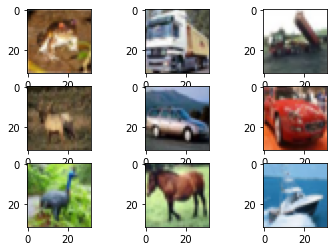

(50000, 32, 32, 3)

In [ ]:
from keras.datasets import cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full.shape

In [ ]:
# Upscale the images to enable the usage of models which reuire a minimal input size of larger than 32x32
## Note: We use the BICUBIC rezise method, as this one appears to be the most efficient for upscaling
X_train_full = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,84,84,method=ResizeMethod.BICUBIC))(X_train_full).numpy()
X_test = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x,84,84,method=ResizeMethod.BICUBIC))(X_test).numpy()

In [ ]:
# Preporcess the input data
X_train_full = preprocess_input(X_train_full)
X_test = preprocess_input(X_test)

# Transform the classes within the label into a one-hot encoding matrix
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

X_train_full.shape

(50000, 84, 84, 3)

In [ ]:
# Get a validation dataset. We decide to take 5000 randomly chosen images from the full training data as the validation dataset
np.random.seed(7)
shuffler = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffler[:5000]], X_train_full[shuffler[5000:]]
y_valid, y_train = y_train_full[shuffler[:5000]], y_train_full[shuffler[5000:]]

## Build and train the model

Build and train your model. 

In [ ]:
# Import the Densenet model with the weights learned for the imagenet competition
## Note: We do not include the dense layers in the top of the model and adjust the input shape to the shape of our data
DenseNet_model = DenseNet201(include_top=False, input_shape=(71, 71, 3), weights="imagenet")
DenseNet_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 77, 77, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 36, 36, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 36, 36, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
DenseNet_model.layers[-567].output

<KerasTensor: shape=(None, 4, 4, 256) dtype=float32 (created by layer 'pool3_pool')>

In [ ]:
### DenseNet201 Final Version ### (92.9% accuracy after 3 epochs with batchsize 50 and lr = 0.0002)

# Import the DenseNet201 model with the weights learned for the imagenet competition
## Note: We do not include the dense layers in the top of the model and adjust the input shape to the shape of our data
DenseNet_model = DenseNet201(include_top=False, input_shape=(84, 84, 3), weights="imagenet")

# We take the full model and build our own trainable fully connected dense layers on top of it
## Note: we leave the last two blocks of the model fully trainable
x = DenseNet_model.output
# Flatten the features to transfrom the inputs into a 1D array
x = Flatten()(x)
x = BatchNormalization()(x)
# Add a sequence of dense layers
x = Dense(256, activation="relu", kernel_initializer="he_normal")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu", kernel_initializer="he_normal")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
x = Dense(64, activation="relu", kernel_initializer="he_normal")(x)
x = Dropout(0.3)(x)
# Add an output layer with softmax activation for the 10 classes
output = Dense(10, activation="softmax")(x)
# Assign the model to the model variable
model = keras.Model(inputs=DenseNet_model.input, outputs=output)

# Freeze the first three blocks of layers from the ResNet model
for layer in DenseNet_model.layers[:-567]:
  layer.trainable=False

In [ ]:
# Compile the model
## Note:
### As usual in classification problems we use the categorical crossentropy as the loss function
### We use the Adam method as the optimizer with learning rate 0.0002
### We set the argument metrics to "accuracy", such that Keras computes and outputs the accuracy of the model on the validation set while it is trained
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0002),
              metrics=["accuracy"])

# To ensure that our model training histories are labelled nicely in tensorboard including a time indication of when the model has been fitted, 
## we define a variable to capture the exact logdirectory and assign this directory to the tensorboard callback afterwards.
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cb = TensorBoard(logdir, histogram_freq=1)

# To prevent overfitting, we introduce early stopping, such that the training is stopped as soon as no improovement has been monitored over 10 periods according to the validation accuracy
early_stopping_cb = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
#early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the model for 3 epochs
history = model.fit(X_train, y_train, batch_size=50, epochs=3, verbose=1,
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping_cb, tensorboard_cb])

Epoch 1/3
900/900 [==============================] - 368s 373ms/step - loss: 1.1216 - accuracy: 0.6518 - val_loss: 0.2803 - val_accuracy: 0.9108
Epoch 2/3
900/900 [==============================] - 329s 365ms/step - loss: 0.3198 - accuracy: 0.9103 - val_loss: 0.2428 - val_accuracy: 0.9256
Epoch 3/3
900/900 [==============================] - 329s 366ms/step - loss: 0.2222 - accuracy: 0.9402 - val_loss: 0.2427 - val_accuracy: 0.9298


In [ ]:
# Train model with data Augmentation

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, zoom_range=0.1)
train_data_aug = datagen.flow(X_train, y_train, batch_size=32)

# Train the model on augmented data
history = model.fit(train_data_aug, steps_per_epoch=len(X_train)/32, epochs=50, verbose=1,
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stopping_cb, tensorboard_cb])

Epoch 1/50
1406/1406 [==============================] - 454s 300ms/step - loss: 1.2935 - accuracy: 0.5989 - val_loss: 0.2960 - val_accuracy: 0.9080
Epoch 2/50
1406/1406 [==============================] - 414s 294ms/step - loss: 0.5098 - accuracy: 0.8505 - val_loss: 0.2784 - val_accuracy: 0.9096
Epoch 3/50
1406/1406 [==============================] - 414s 295ms/step - loss: 0.3940 - accuracy: 0.8874 - val_loss: 0.2532 - val_accuracy: 0.9222
Epoch 4/50
1406/1406 [==============================] - 414s 294ms/step - loss: 0.3388 - accuracy: 0.9028 - val_loss: 0.2234 - val_accuracy: 0.9254
Epoch 5/50
1406/1406 [==============================] - 414s 294ms/step - loss: 0.2981 - accuracy: 0.9128 - val_loss: 0.2255 - val_accuracy: 0.9320
Epoch 6/50
1406/1406 [==============================] - 414s 294ms/step - loss: 0.2592 - accuracy: 0.9222 - val_loss: 0.2011 - val_accuracy: 0.9406
Epoch 7/50
1406/1406 [==============================] - 414s 295ms/step - loss: 0.2242 - accuracy: 0.9356 - val_

In [ ]:
# show the structure of your model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 84, 84, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 90, 90, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 42, 42, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 42, 42, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

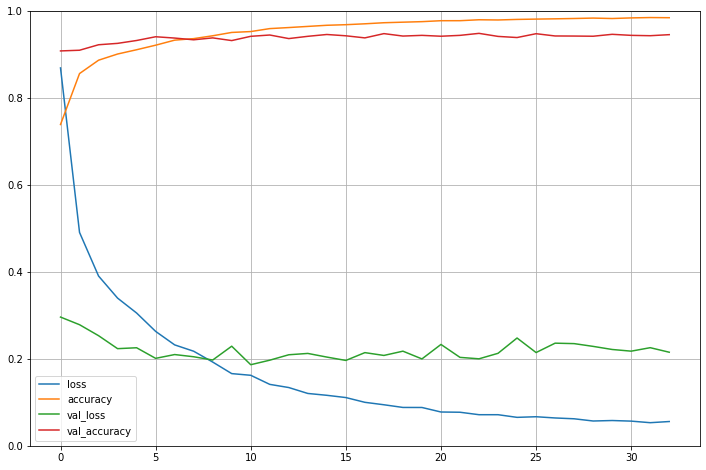

In [ ]:
# Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

In [ ]:
model.save('cifar10.h5')

In [ ]:
# Download the model directly
from google.colab import files
files.download('cifar10.h5')

## Load the model and evaluate it on the test data

In [ ]:
model = keras.models.load_model("cifar10.h5")
model.evaluate(X_test, y_test)

313/313 [==============================] - 42s 124ms/step - loss: 0.2026 - accuracy: 0.9453


[0.20256158709526062, 0.9452999830245972]

In [ ]:
# OWN: Model Evaluation
model.evaluate(X_test, y_test)

313/313 [==============================] - 40s 129ms/step - loss: 0.2026 - accuracy: 0.9453


[0.20256158709526062, 0.9452999830245972]

## Short report

Please write briefly how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model, and the difficulties you met.

### Report:

In order to create a Convolutional Neural Networkk (CNN) that enables us to accurately depict the dataset, we commenced by taking advantage of a transfer learning technique. As such, we attempted to find an existing neural network that accomplishes a similar task and reuse the lower hidden layers of the network. As such, we first looked at potential candidates by screening models which were discussed in class. Especially, we were keen on trying Xception, ResNet as well as Inception as our primary models. This was based on the notion that these three models provided us with the best possible trade-off between model depth and initial accuracy scores. Also, these nets were all used for similar classification tasks in image-based prediction settings. Further, since we assumed that running said models might require a substantial amount of time, we deemed it necessary to primarily focus on a small number of models such that time constraints can be adhered to. 

When assessing each model, we realized that some require a minimum size of 71 x 71 pixels. Unfortunately, this is a baseline requirement the data does not fulfill, as it is primarily given in a format shape of 32 x 32 pixels. As such, we initially focused on models which can be estimated with the baseline shape, leading us to ResNet152V2, DenseNet121, DenseNet201 and VGG19. In principal, we followed a similar strategy for our initial set-up of each model. Initially, we imported each model with weights trained for the imagenet dataset, excluding the top dense layers. Then, we defined our input according to the 'preprocess input' function and performed the preprocess steps on the data such that each model was able to work with it. Having the data prepared, we defined an initial model status prior to the convolutional frames, defined as 3 hidden and fully connected dense layers with a decreasing number of neurons per layer (starting with 512, 256 and 128 neurons each), a relu activation function as well as he normal initialization, subsequent dropout layers with a rate of 0.3 to account for robustness as well as batch normalization following the initial two layers. As a side note, we decided not to include a batch normalization on the last layer due to the already high computational complexity of our model. As such, we traded-off computational complexity as we deemed that the last normalization might be redundant. Lastly, we included a softmax activation function with 10 neurons, as a best practice method.

Having set up the entire network, we iteratively omitted the respective last frame of convolutional layers from the network, held the weights of the remaining construct, used a batch size of 30 and the adam optimizer to 0.0001 (both were obtained through experiments and showed the best effect) and trained the resulting model for 3 epochs. Afterwards, we repeated the process sequentially by removing each convolutional frame and ranked the respective validation errors for each model. 

Taking all together, we observed that the DenseNet201 leads to the most appropriate prediction, with an accuracy of slightly above 80%. 

However, finding that we were only able to slightly beat the required threshold, we were curious whether some models which require a different initial shape size could outperform the given model. We were able to find a manual on how to upscale the pixel values to make it run on the Xception model. Using said model with the same specifications as given above, we were able to retrieve a prediction accuracy which was 8-10% higher than the one from the best model we tried so far. We then attempted to understand whether this was based on the model structure or rather on the upscaling of the images. As such, we applied the upscaling procedure on the DenseNet201 and observed that, now, DenseNet outperforms XCeption by approximately 2%. As such, we conclude that upscaling of images leads to an improved prediction accuracy, irrespective of model selection. One intuition behind this result might be that an increased pixel size has a greater initial resolution. Since we work with an enhanced image classification dataset consisting of many nuanced characteristics, a greater pixel size could cause a better resolution as the convolution is able to depict a bigger amount of individual features the images contain. As such, we are able to mirror more precise features of the images compared to lower-sized frames. 

Having used the upscaling strategy on both models, we decided to use the original DenseNet201 as primary model. Conducting additional research on how to improve the performance of a model, we found that, during transfer learning processes, one does not necessarily have to exclude the last frames of the convolutional layers entirely, but can rather unfreeze their weights and retrain these. Trying whether this again would induce better performance, we found that this is indeed the case, but, apparently, with the cost of increasing training time. As such, we obtained a model with the initial three frames frozen and the last two trainable and the identical model construct as described above. 

Since time permitted us to do so, we then randomly selected some model parameters, similar to the initialization strategy of the ANN task in part 1, and tried some hyperparameter combinations. As such, we used 2 or 3 hidden layers, used different number of initial neurons (starting from 256, 1024 as well as 128 and declining the number by a factor of 2), attempted numerous learning rates. Note that we did not use different batch sizes as these would anyhow be determined by the data augmentation which we applied to each model. 

Overall, we created a model which best predicted with 3 hidden layers, with neurons of (256, 128, 64) and a learning rate of 0.0002 for the adam optimizer.

Lastly, we attempted whether further upscaling would again induce better performance. As such, we tried to find the maximum possible shape of the images, such that the model was still able to fit into the 12 GB restricted ram of the google colab GPU. Working this out, we figured that an 84 x 84 pixel shape appear to still function. 

We then estimated the model during 50 epochs and introduced an early stopping mechanism with a patience of 10 steps. Further, we assigned a data augmentation strategy with rotation, width as well as height shift, horizontal flip and zoom and a batch size given by the model of 32. 

Taking all these parts into consideration, we applied a TransferLearning technique using the construct of the DenseNet201 including:

- 3 Hidden Layers 
- Neurons per Layer of 256, 128 and 64
- Learning Rate of 0.0002
- Adam Optimizer 
- ReLu Activation function with He-Initializer
- Drop-Out Layers with a rate of 0.3
- Three convolutional frames frozen and two trainable
- Batch Size of 32
- Upscaled images to 84 x 84 pixels 
- Data augmentation as described above

And obtained a prediction accuracy on the test set of ~94.53%. 